In [1]:
# Run 'source ~/.profile'
import satpy
from satpy import Scene, find_files_and_readers
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyresample import geometry, spherical_geometry
from pyproj import CRS
from satpy import Scene, MultiScene
from satpy.multiscene import timeseries, temporal_rgb, stack
from satpy.writers import to_image
from satpy.composites import GenericCompositor
from datetime import datetime

sys.path.insert(0,'/home/cameron/Projects/')

#print(satpy.config.to_dict())
#print(satpy.available_readers())

files_1 = find_files_and_readers(base_dir="/home/cameron/Dropbox/Data/20220827_CaptureDL_00_erie_2022_08_27T16_05_36/", reader='hypso1_bip')
files_2 = find_files_and_readers(base_dir="/home/cameron/Nedlastinger/20230519_CaptureDL_erie_2023-05-17_1553Z/", reader='hypso1_bip')

#files = find_files_and_readers(base_dir="/home/cameron/Dropbox/Data/20220827_CaptureDL_00_erie_2022_08_27T16_05_36/", reader='hypso1_bip')
#files = find_files_and_readers(base_dir="/home/cameron/Nedlastinger/20231215_CaptureDL_erie_2023-12-14_1543Z/", reader='hypso1_bip')
#files = find_files_and_readers(base_dir="/home/cameron/Dropbox/Data/20231215_CaptureDL_erie_2023-12-14_1543Z/", reader='hypso1_bip')
#files = find_files_and_readers(base_dir="/home/cameron/Nedlastinger/20230821_CaptureDL_erie_2023-08-20_1538Z/", reader='hypso1_bip')
#files = find_files_and_readers(base_dir="/home/cameron/Nedlastinger/20230519_CaptureDL_erie_2023-05-17_1553Z/", reader='hypso1_bip')
#files = find_files_and_readers(base_dir="/home/cameron/Nedlastinger/20230519_CaptureDL_erie_2023-05-17_1553Z/", reader='hypso1_bip')


scene_1 = Scene(filenames=files_1, reader_kwargs={'flip': True})
scene_2 = Scene(filenames=files_2)

datasets_1 = scene_1.available_dataset_names()
datasets_2 = scene_2.available_dataset_names()

# Don't need to load all the datasets just for testing
#scene_1.load(datasets_1)
#scene_2.load(datasets_2)

scene_1.load(['latitude', 'longitude', '80', '40', '15'])
scene_2.load(['latitude', 'longitude', '80', '40', '15'])

#scene_1.save_datasets(writer='cf', datasets=datasets_1, filename='test4.nc', include_lonlats=True)

/tmp/ipykernel_148659/700896466.py:8: DeprecationWarning: This module will be removed in pyresample 2.0, please use the `pyresample.spherical` module functions and class instead.
  from pyresample import geometry, spherical_geometry


[INFO] Flipping capture /home/cameron/Dropbox/Data/20220827_CaptureDL_00_erie_2022_08_27T16_05_36/erie_2022_08_27T16_05_36.bip in the cross track dimension.


In [2]:
swath_def_1 = scene_1['80'].attrs['area']
swath_def_2 = scene_2['80'].attrs['area']

In [8]:
if False:
    scene_1['latitude'].attrs['area'] = scene_1['80'].attrs['area']
    scene_1['longitude'].attrs['area'] = scene_1['80'].attrs['area']

    scene_2['latitude'].attrs['area'] = scene_2['80'].attrs['area']
    scene_2['longitude'].attrs['area'] = scene_2['80'].attrs['area']


grid_lats = scene_1['80'].attrs['area'].lats.data
grid_lons = scene_1['80'].attrs['area'].lons.data

lon_min = grid_lons.min()
lon_max = grid_lons.max()
lat_min = grid_lats.min()
lat_max = grid_lats.max()

bbox = (lon_min,lat_min,lon_max,lat_max)

area_id = 'roi'
proj_id = 'roi'
description = 'roi'
projection = CRS.from_epsg(4326)
width = 1000
height = 1000
area_extent = list(bbox)

area_def = geometry.AreaDefinition(area_id, proj_id, description, projection,  width, height, area_extent)

# https://pyresample.readthedocs.io/en/stable/howtos/geometry_utils.html#writing-to-disk
filename = 'western_lake_erie' + '.yaml'
with open(filename, 'w') as file:
    file.write(area_def.dump())

area_lons = area_def.get_lonlats()[0]
area_lats = area_def.get_lonlats()[1]

local_scene_1 = scene_1.resample(area_def, resampler='bilinear', fill_value=np.NaN)
local_scene_2 = scene_2.resample(area_def, resampler='bilinear', fill_value=np.NaN)

In [7]:
area_def.dump()

str

In [4]:
gamma = 2

s = scene_1
compositor = GenericCompositor("overview")
composite = compositor([s['80'][:,::3], s['40'][:,::3], s['15'][:,::3]]) # Red, Green, Blue
img = to_image(composite)
img.invert([False, False, False])
img.stretch("linear")
img.gamma([gamma, gamma, gamma])
img.save('scene1.png')

s = scene_2
compositor = GenericCompositor("overview")
composite = compositor([s['80'][:,::3], s['40'][:,::3], s['15'][:,::3]]) # Red, Green, Blue
img = to_image(composite)
img.invert([False, False, False])
img.stretch("linear")
img.gamma([gamma, gamma, gamma])
img.save('scene2.png')

s = local_scene_1
compositor = GenericCompositor("overview")
composite = compositor([s['80'], s['40'], s['15']]) # Red, Green, Blue
img = to_image(composite)
img.invert([False, False, False])
img.stretch("linear")
img.gamma([gamma, gamma, gamma])
img.save('scene1_resampled.png')

s = local_scene_2
compositor = GenericCompositor("overview")
composite = compositor([s['80'], s['40'], s['15']]) # Red, Green, Blue
img = to_image(composite)
img.invert([False, False, False])
img.stretch("linear")
img.gamma([gamma, gamma, gamma])
img.save('scene2_resampled.png')

/home/cameron/miniforge3/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/cameron/miniforge3/lib/python3.10/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [59]:
from pyresample.spherical_utils import GetNonOverlapUnions
from pyresample import spherical_geometry 
from pyresample.boundary import AreaDefBoundary, Boundary
import pyresample

area_boundary_1 = Boundary(lons=swath_def_1.lons, lats=swath_def_1.lats, frequency=1000)
#area_boundary_1 = area_boundary_1.contour_poly 

area_boundary_2 = Boundary(lons=swath_def_2.lons, lats=swath_def_2.lats, frequency=1000)
#area_boundary_2 = area_boundary_2.contour_poly 

#print(type(area_boundary_1))
#print(type(area_boundary_2))

swath_intersections, b = pyresample.spherical_geometry.get_intersections(swath_def_2, [swath_def_1])

area_boundary_1_contour = area_boundary_1.contour()

lons, lats, data = pyresample.data_reduce.swath_from_lonlat_grid(area_boundary_1_contour[0].to_numpy(), 
                                                    area_boundary_1_contour[1].to_numpy(), 
                                                    swath_def_1.lons.to_numpy(), 
                                                    swath_def_1.lats.to_numpy(), 
                                                    scene_1['80'].to_numpy(), 
                                                    radius_of_influence=300)

point = pyresample.spherical_geometry.Coordinate(lon=-10, lat=20) 
pyresample.spherical_geometry.point_inside(point, swath_intersections[0])

# Possible approach:
# Load swath lat and lons
# Check validity of each coord using pyresample.spherical_geometry.point_inside
# Create new swath?

False

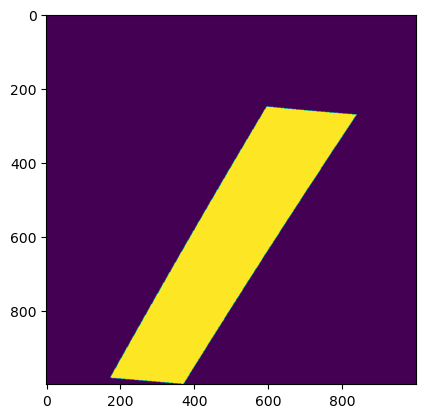

In [56]:

mask_1 = local_scene_1['80'].values
mask_1 = ~np.isnan(mask_1)

mask_2 = local_scene_2['80'].values
mask_2 = ~np.isnan(mask_2)

mask = mask_1 & mask_2

local_scene_2['15'].values = mask

plt.imshow(mask)

In [3]:
scenes = [local_scene_1, local_scene_2]
mscn = MultiScene(scenes)
mscn.load(['latitude', 'longitude', '80', '40', '15'])
new_mscn = mscn.resample(area_def)
#new_mscn = mscn
#blended_scene = new_mscn.blend()
print(new_mscn.loaded_dataset_ids)
blended_scene = new_mscn.blend(blend_function=timeseries)
blended_scene.load(datasets_1)
blended_scene.load(['latitude', 'longitude', '80', '40', '15'])

{DataID(name='3', wavelength=399, modifiers=()), DataID(name='84', wavelength=682, modifiers=()), DataID(name='10', wavelength=423, modifiers=()), DataID(name='39', wavelength=526, modifiers=()), DataID(name='88', wavelength=696, modifiers=()), DataID(name='23', wavelength=469, modifiers=()), DataID(name='92', wavelength=710, modifiers=()), DataID(name='116', wavelength=792, modifiers=()), DataID(name='21', wavelength=462, modifiers=()), DataID(name='4', wavelength=402, modifiers=()), DataID(name='114', wavelength=785, modifiers=()), DataID(name='53', wavelength=575, modifiers=()), DataID(name='61', wavelength=603, modifiers=()), DataID(name='46', wavelength=550, modifiers=()), DataID(name='91', wavelength=707, modifiers=()), DataID(name='52', wavelength=571, modifiers=()), DataID(name='60', wavelength=599, modifiers=()), DataID(name='1', wavelength=391, modifiers=()), DataID(name='75', wavelength=651, modifiers=()), DataID(name='40', wavelength=529, modifiers=()), DataID(name='110', w

In [44]:
x = blended_scene.to_xarray_dataset()
#x = x.to_array()

In [60]:
scene_1

In [55]:

import xarray as xr


# Set data to NaN where there are NaN values at corresponding locations in other time steps
#x['80'] = xr.where(np.isnan(x['80'].shift(time=1)), np.nan, x['80'])
x['80'] = xr.where(np.isnan(x['80'][0,:,:]), np.nan, x['80'])


In [58]:
y = x['80'].to_numpy()

In [59]:
y.shape

(1000, 1000, 2)

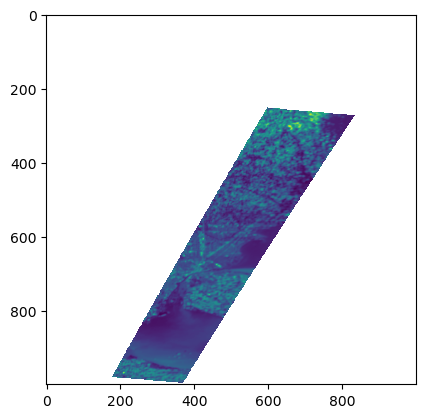

In [63]:
plt.imshow(y[:,:,1])

In [71]:

#
composite = temporal_rgb([scene_1['80'], scene_1['40'], scene_1['15']])

img = to_image(composite)
img.invert([False, False, False])
img.stretch("linear")
img.gamma([1.9, 1.9, 1.9])
img.save('blended.png')

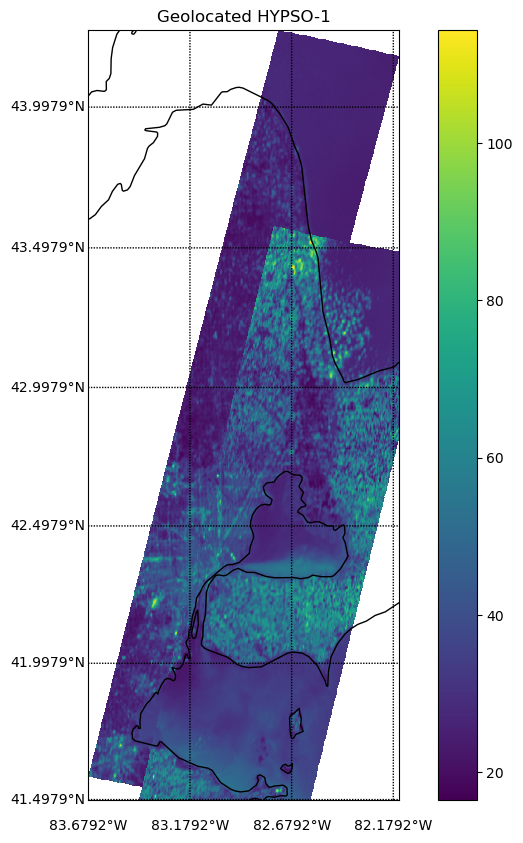

In [53]:
from mpl_toolkits.basemap import Basemap

from matplotlib import pyplot as plt

#plt.figure(figsize = (10,10))
a1 = local_scene_1['80'].to_numpy()
a2 = local_scene_2['80'].to_numpy()
masked_a1 = np.ma.masked_equal(a1, -999)
masked_a2 = np.ma.masked_equal(a2, -999)
#plt.imshow(masked_a2)


grid_lons, grid_lats = area_def.get_lonlats()

lon_min = grid_lons.min()
lon_max = grid_lons.max()
lat_min = grid_lats.min()
lat_max = grid_lats.max()

lon = grid_lons
lat = grid_lats
data1 = masked_a1
data2 = masked_a2

fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(projection='merc', llcrnrlat=bbox[1], urcrnrlat=bbox[3],
            llcrnrlon=bbox[0], urcrnrlon=bbox[2], resolution='h')

x, y = m(lon, lat)

m.pcolormesh(x, y, data1)
m.pcolormesh(x, y, data2)
plt.colorbar()

m.drawcoastlines()
m.drawparallels(np.arange(lat_min, lat_max, 0.5), labels=[1,0,0,0])
m.drawmeridians(np.arange(lon_min, lon_max, 0.5), labels=[0,0,0,1])

# Set title
plt.title('Geolocated HYPSO-1')

# Save plot
#plt.savefig(out_dir + 'after_tsm' + '.png')
plt.show()
#plt.close()

In [7]:
composite

<xarray.DataArray 'where-d83fe5646c77c2bfe0ce509dbd65995c' (bands: 3, y: 1000,
                                                            x: 1000)>
dask.array<where, shape=(3, 1000, 1000), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -83.68 -83.68 -83.68 -83.67 ... -82.15 -82.15 -82.15
  * y        (y) float64 44.27 44.27 44.26 44.26 44.26 ... 41.51 41.5 41.5 41.5
    crs      object GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ens...
  * bands    (bands) <U1 'R' 'G' 'B'
Attributes: (12/13)
    calibration_info:        {'bin_factor': 9, 'bin_x': 9, 'background_value'...
    ancillary_variables:     []
    end_time:                2023-05-17 15:53:00
    time:                    2023-05-17 15:53:00
    reader:                  hypso1_bip
    start_time:              2023-05-17 15:53:00
    ...                      ...
    wavelength:              None
    name:                    overview
    prerequisites:           []
    optional_prerequisites:  []
    sensor:                  None
    mode:                    RGB

In [42]:
composite_numpy = composite.to_numpy()
composite_numpy = np.transpose(composite_numpy, (1,2,0))
composite_numpy.shape

(1000, 1000, 3)

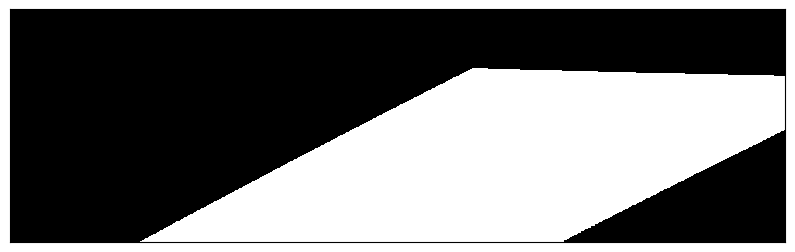

In [48]:
from mpl_toolkits.basemap import Basemap




rgb = np.zeros((1000, 1000, 3))

#mins = [er[:,:,i].min() for i in range(120)]

rgb[:,:,0] = composite_numpy[:,:,0]
rgb[:,:,1] = composite_numpy[:,:,1]
rgb[:,:,2] = composite_numpy[:,:,2]

#rgb[0:,:] = er[:,:,65]-mins[65]
#rgb[1,:,:] = er[:,:,47]-mins[47]
#rgb[2,:,:] = er[:,:,20]-mins[20]

#rgb /= (0.4*rgb[~sat].max())
#rgb[sat] = 1

fig, ax = plt.subplots(1,figsize=(10,10))
#plt.imshow(np.rot90(rgb), aspect=0.3)
plt.imshow(rgb, aspect=0.3)
plt.xticks([])
plt.yticks([])
plt.savefig("erie.png")





In [56]:
max_value = np.nanmax(rgb)
min_value = np.nanmax(rgb)
normalized_matrix = (rgb - min_value) / (max_value - min_value)

/tmp/ipykernel_96136/1558298892.py:3: RuntimeWarning: divide by zero encountered in divide
  normalized_matrix = (rgb - min_value) / (max_value - min_value)
/tmp/ipykernel_96136/1558298892.py:3: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = (rgb - min_value) / (max_value - min_value)


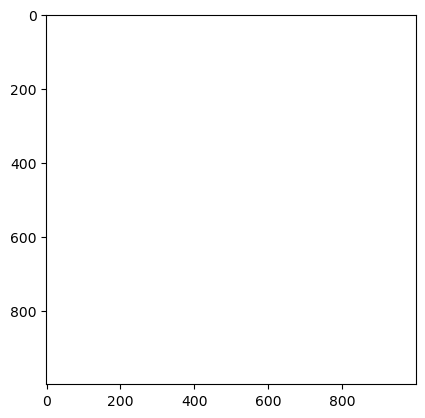

In [61]:
plt.imshow(normalized_matrix[:,:,0])

In [ ]:
grid_lons, grid_lats = area_def.get_lonlats()

lon_min = grid_lons.min()
lon_max = grid_lons.max()
lat_min = grid_lats.min()
lat_max = grid_lats.max()

masked_a1 = np.ma.masked_equal(a1, np.nan)
masked_a2 = np.ma.masked_equal(a2, np.nan)

lon = grid_lons
lat = grid_lats
data1 = rgb

fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(projection='merc', llcrnrlat=bbox[1], urcrnrlat=bbox[3],
            llcrnrlon=bbox[0], urcrnrlon=bbox[2], resolution='h')

x, y = m(lon, lat)

m.pcolormesh(x, y, data1)
m.pcolormesh(x, y, data2)
plt.colorbar()

m.drawcoastlines()
m.drawparallels(np.arange(lat_min, lat_max, 0.5), labels=[1,0,0,0])
m.drawmeridians(np.arange(lon_min, lon_max, 0.5), labels=[0,0,0,1])

# Set title
plt.title('Geolocated HYPSO-1')

# Save plot
#plt.savefig(out_dir + 'after_tsm' + '.png')
plt.show()
#plt.close()